In [28]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import Audio

from sklearn.model_selection import KFold

In [2]:
meta = pd.read_csv('../../training.csv')
test_meta = pd.read_csv('../../test.csv')

## time

In [3]:
train_times = []
for name in meta['path']:
    y, sr = librosa.load('../../' + name)
    train_times.append(len(y)/ sr)
train_times = pd.Series(train_times)
train_times.describe()

count    2700.000000
mean        0.438810
std         0.149941
min         0.143537
25%         0.342268
50%         0.420590
75%         0.512653
max         2.282766
dtype: float64

<AxesSubplot:>

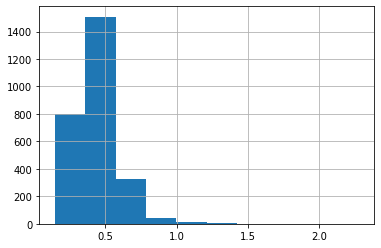

In [4]:
train_times.hist()

In [5]:
t = [item for item in train_times if item <= 1.0]
len(t)

2682

In [6]:
test_times = []
for name in test_meta['path']:
    y, sr = librosa.load('../../' + name)
    test_times.append(len(y)/ sr)
test_times = pd.Series(test_times)
test_times.describe()

count    300.000000
mean       0.425273
std        0.124639
min        0.195011
25%        0.342914
50%        0.410590
75%        0.493934
max        1.038639
dtype: float64

<AxesSubplot:>

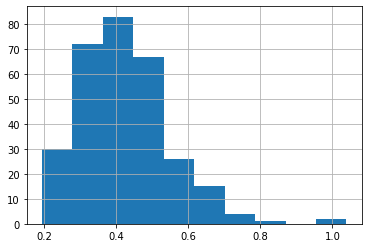

In [7]:
test_times.hist()

In [8]:
t = [item for item in test_times if item <= 1.0]
len(t)

298

In [12]:
long_audio_idxes = [i for i in range(len(train_times)) if train_times[i] > 1.0]
len(long_audio_idxes)

18

In [31]:
# for idx in long_audio_idxes:
#     y, sr = librosa.load('../../' + meta['path'].loc[int(idx)])
#     ipd.display(Audio(y, rate=sr))

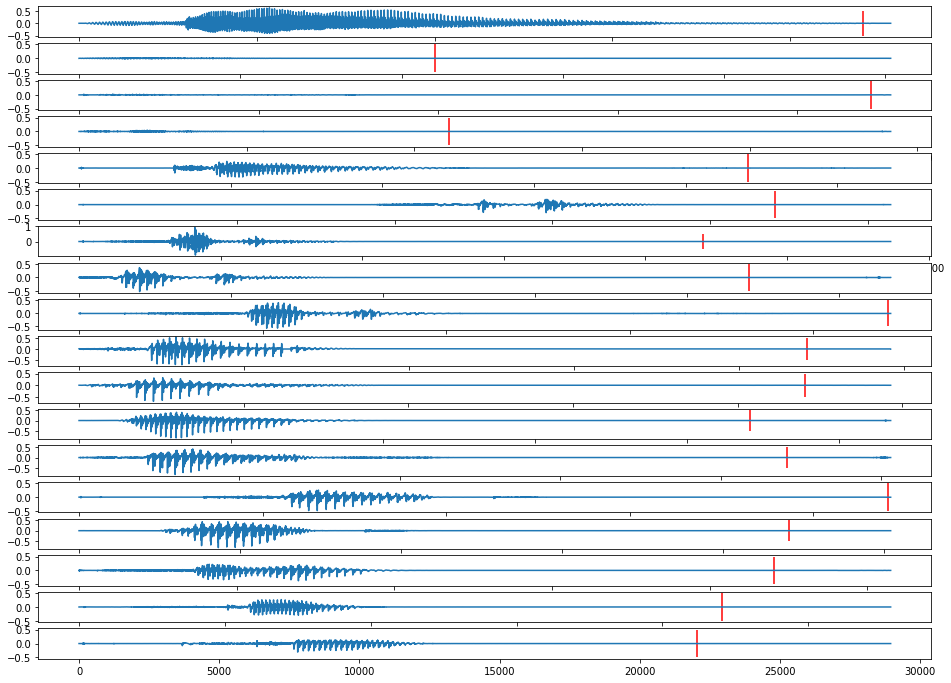

In [38]:
fig, axes = plt.subplots(len(long_audio_idxes), figsize=(16,12))
for i, idx in enumerate(long_audio_idxes):
    y, sr = librosa.load('../../' + meta['path'].loc[int(idx)])
    axes[i].plot(y)
    axes[i].vlines([sr], -0.5, 0.5, "red")

In [9]:
# # make new meta
# # meta = pd.read_csv('../training.csv')
# name_list = []
# label_list = []
# for i in range(len(meta)):
#     if train_times[i] <= 1.0:
#         name_list.append(meta['path'][i])
#         label_list.append(meta['label'][i])
# new_meta = pd.DataFrame(list(zip(name_list, label_list)), columns=['path', 'label'])
# # new_meta.to_csv('../new_training.csv', index=False)

In [10]:
# # make new meta
# name_list = []
# for i in range(len(test_meta)):
#     if test_times[i] <= 1.0:
#         name_list.append(test_meta['path'][i])
# df = pd.DataFrame(name_list, columns=['path'])
# df.to_csv('../new_test.csv', index=False)

### relation of number and audio time

In [11]:
meta['times'] = train_times
meta.head()

,path,label,times
0,dataset/train/jackson_0.wav,4,0.502902
1,dataset/train/jackson_1.wav,4,0.429252
2,dataset/train/jackson_2.wav,4,0.484898
3,dataset/train/jackson_3.wav,4,0.440272
4,dataset/train/jackson_4.wav,4,0.454512


In [12]:
meta.groupby('label').describe()['times']

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,270.0,0.503607,0.126826,0.271791,0.405850,0.487528,0.591735,1.167664
1,270.0,0.403095,0.127845,0.174875,0.306757,0.377778,0.482551,0.941542
2,270.0,0.385760,0.140438,0.161043,0.288379,0.356576,0.471168,1.213379
3,270.0,0.402025,0.154027,0.181905,0.284966,0.381655,0.496814,1.313016
4,270.0,0.409257,0.111757,0.169887,0.331179,0.397642,0.470329,1.114875
5,270.0,0.453843,0.120902,0.209161,0.378061,0.424580,0.512619,1.147256
6,270.0,0.453374,0.182824,0.143537,0.319002,0.444195,0.569875,0.977506
7,270.0,0.461145,0.178380,0.245669,0.367370,0.438753,0.507336,2.195918
8,270.0,0.415019,0.119294,0.218639,0.342857,0.400703,0.467268,1.142902


## Baseline extract features

In [13]:
def feature_extraction(path_list):
    """
    wavファイルのリストから特徴抽出を行い，リストで返す
    扱う特徴量はMFCC13次元の平均（0次は含めない）
    Args:
        path_list: 特徴抽出するファイルのパスリスト
    Returns:
        features: 特徴量
    """

    load_data = (lambda path: librosa.load('../../' + path)[0])

    data = list(map(load_data, path_list))
    features = np.array([np.mean(librosa.feature.mfcc(y=y, n_mfcc=13), axis=1) for y in data])

    return features

In [14]:
features = feature_extraction(list(meta['path']))
features.shape

(2700, 13)

## meta

<AxesSubplot:>

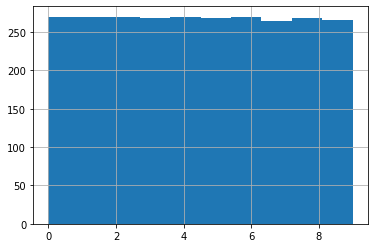

In [15]:
new_meta['label'].hist()

In [16]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=lw, cmap=cmap_data)

    # Formatting
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

<AxesSubplot:title={'center':'KFold'}>

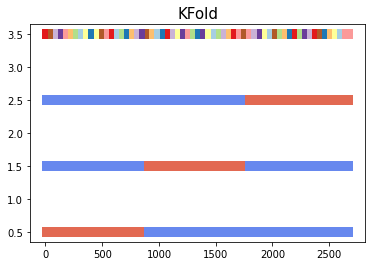

In [17]:
fig, ax = plt.subplots()
n_splits = 3
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
cv = KFold(n_splits)
idxes = [i for i in range(len(new_meta))]
X = idxes
y = new_meta['label'].values
groups = new_meta['label'].values
plot_cv_indices(cv, X, y, groups, ax, n_splits)

## mel spectrogram

In [59]:
def mel_spec(input: np.ndarray, sr: int, win_size: int, hop_len: int, n_mels: int, ) -> np.ndarray:
    spec = librosa.stft(
        y=input, n_fft=win_size, win_length=win_size, hop_length=hop_len)
    spec = np.abs(spec) ** 2.0

    mel_filter_bank = librosa.filters.mel(sr=sr, n_fft=win_size, n_mels=n_mels)
    mel = np.dot(mel_filter_bank, spec)

#     mel = librosa.feature.melspectrogram(
#         y=input, sr=sr, n_mels=80, n_fft=win_size, win_length=win_size, hop_length=hop_len)
#     log_mel = np.log(mel)

    return mel

In [56]:
y, sr = librosa.load('../../' + meta['path'].loc[456])
Audio(y, rate=sr)

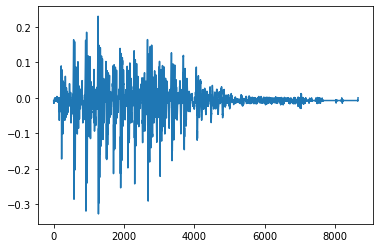

In [57]:
plt.plot(y)

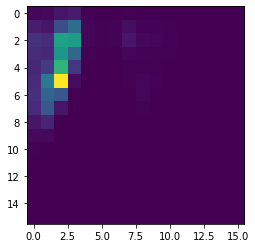

In [64]:
win_size = int(sr*0.05)
overlap = 0.5
n_mels = 16
feature = mel_spec(y, sr, win_size, int(win_size*overlap), n_mels)
feature = np.float32(feature.T[:, :])
plt.imshow(feature)